# TECHNICAL REPORT: VRP with Increased Capacity (80 kg)

## 1. Introduction and Scenario Change

This experiment addresses the **Vehicle Routing Problem with Capacity (CVRP)** under a new operational constraint. Unlike the previous scenario, the fleet capacity has been increased to **80 kg**.

**Experiment Objective:**
To analyze how the capacity increase affects **customer feasibility** and **route efficiency**. Specifically, we seek to integrate the customer with the highest demand (C5), who was previously excluded, and minimize the total distance traveled while serving 100% of the customer portfolio.

## 2. Data Analysis and Constraints

### 2.1. Demand Profile
The calculated demands for the 5 customers are:

| Customer | Demand (kg) | Status (Cap. 60) | Status (Cap. 80) |
| :---: | :---: | :---: | :---: |
| C1 | 18.6 | Valid | **Valid** |
| C2 | 22.8 | Valid | **Valid** |
| C3 | 48.0 | Valid | **Valid** |
| C4 | 60.0 | Valid | **Valid** |
| C5 | **77.7** | *Invalid* | **Valid** |

### 2.2. Impact of New Capacity
The shift to 80 kg has a critical impact:
1.  **Total Inclusion:** Customer 5 (77.7 kg) now meets the constraint ($77.7 \le 80$). The Genetic Algorithm (GA) must now optimize a route for **5 customers** instead of 4.
2.  **Load Saturation:** Customer 5 will occupy 97% of a truck's capacity, practically forcing an exclusive trip for them (as only 2.3 kg remain free and no other customer has such small demand).
3.  **Combinatorics:** The extra capacity allows for new groupings. For example, C4 (60 kg) now leaves 20 kg free, allowing it to be grouped with C1 (18.6 kg), something impossible with the 60 kg capacity.

## 3. Methodology (Genetic Algorithm)

The GA configuration is maintained to ensure comparability:
* **Representation:** Permutation of indices of all valid customers.
* **Evaluation (Fitness):** Total Euclidean distance.
* **Route Decoding:** "Next Fit" Heuristic (fill the vehicle until the next customer does not fit, return to depot, and start new route).
* **Parameters:** 200 Generations, Population of 50 individuals.

--- 
### Code Implementation
*Below are the code cells for the experiment execution.*

In [1]:
import random
import math
import matplotlib.pyplot as plt

# Problem data
depot = [20, 120]
customers = [
    [35, 115], [50, 140], [70, 100], [40, 80], [25, 60]
]

weights = [1.2, 3.8, 7.5, 0.9, 15.4, 12.1, 4.3, 19.7, 8.6, 2.5]

orders = [
    [(3, 2), (1, 3)],
    [(2, 6)],
    [(7, 4), (5, 2)],
    [(3, 8)],
    [(6, 5), (9, 2)]
]

In [2]:
# 3. Demand Calculation and Capacity Definition
demands = []
for order in orders:
    total = 0
    for item, qty in order:
        total += weights[item - 1] * qty
    demands.append(total)

# HERE IS THE KEY CHANGE: Capacity increased to 80
capacity = 80

print('Calculated demands:', [round(d, 1) for d in demands])
print(f'Vehicle capacity: {capacity} kg')

Calculated demands: [18.6, 22.8, 48.0, 60.0, 77.7]
Vehicle capacity: 80 kg


In [3]:
# 4. Customer filtering
valid_customers = []
valid_demands = []
invalid_customers = []
invalid_demands = []

for i in range(len(customers)):
    if demands[i] <= capacity:
        valid_customers.append(customers[i])
        valid_demands.append(demands[i])
    else:
        invalid_customers.append(customers[i])
        invalid_demands.append(demands[i])

print(f'Valid customers: {len(valid_customers)} (All included)')
print(f'Invalid customers: {len(invalid_customers)}')

Valid customers: 5 (All included)
Invalid customers: 0


In [4]:
# 5. GA Functions (Distance, Fitness, Crossover, Mutation)
def distance(a, b):
    return math.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

def split_into_routes(route):
    routes = []
    load = 0
    current_route = []
    for c in route:
        if load + valid_demands[c] <= capacity:
            current_route.append(c)
            load += valid_demands[c]
        else:
            routes.append(current_route)
            current_route = [c]
            load = valid_demands[c]
    if current_route:
        routes.append(current_route)
    return routes

def total_distance(route):
    routes = split_into_routes(route)
    total = 0
    for r in routes:
        pos = depot
        for c in r:
            total += distance(pos, valid_customers[c])
            pos = valid_customers[c]
        total += distance(pos, depot)
    return total

def fitness(route):
    return total_distance(route)

def create_population(n, num_customers):
    population = []
    base = list(range(num_customers))
    for _ in range(n):
        r = base[:]
        random.shuffle(r)
        population.append(r)
    return population

def selection(population, fitness_values):
    i1, i2 = random.sample(range(len(population)), 2)
    return population[i1][:] if fitness_values[i1] < fitness_values[i2] else population[i2][:]

def crossover(p1, p2):
    a, b = sorted(random.sample(range(len(p1)), 2))
    child = [-1] * len(p1)
    child[a:b] = p1[a:b]
    pos = b
    for x in p2:
        if x not in child:
            if pos >= len(p1): pos = 0
            child[pos] = x
            pos += 1
    return child

def mutation(route, prob=0.1):
    if random.random() < prob:
        i, j = random.sample(range(len(route)), 2)
        route[i], route[j] = route[j], route[i]

def genetic_algorithm(n_generations=200, pop_size=50):
    population = create_population(pop_size, len(valid_customers))
    fitness_values = [fitness(r) for r in population]

    for _ in range(n_generations):
        new_population = []
        for _ in range(pop_size):
            p1 = selection(population, fitness_values)
            p2 = selection(population, fitness_values)
            child = crossover(p1, p2)
            mutation(child, 0.1)
            new_population.append(child)
        population = new_population
        fitness_values = [fitness(r) for r in population]

    best_idx = min(range(pop_size), key=lambda i: fitness_values[i])
    return population[best_idx], fitness_values[best_idx]

## 4. Execution and Results Analysis

When executing the algorithm with the new capacity, very efficient grouping behavior is observed. The results are shown below:

In [5]:
best_route, best_value = genetic_algorithm()

print('Best sequence (indices):', best_route)
print('Total distance:', round(best_value, 2))

print("\n--- Detail of Generated Routes ---")
routes = split_into_routes(best_route)
for i, r in enumerate(routes):
    load = sum(valid_demands[c] for c in r)
    capacity_usage = (load / capacity) * 100
    print(f'Trip {i+1}: Customers {r} -> Load: {round(load, 1)} kg ({round(capacity_usage, 1)}% occupancy)')

Best sequence (indices): [4, 2, 1, 0, 3]
Total distance: 350.93

--- Detail of Generated Routes ---
Trip 1: Customers [4] -> Load: 77.7 kg (97.1% occupancy)
Trip 2: Customers [2, 1] -> Load: 70.8 kg (88.5% occupancy)
Trip 3: Customers [0, 3] -> Load: 78.6 kg (98.2% occupancy)


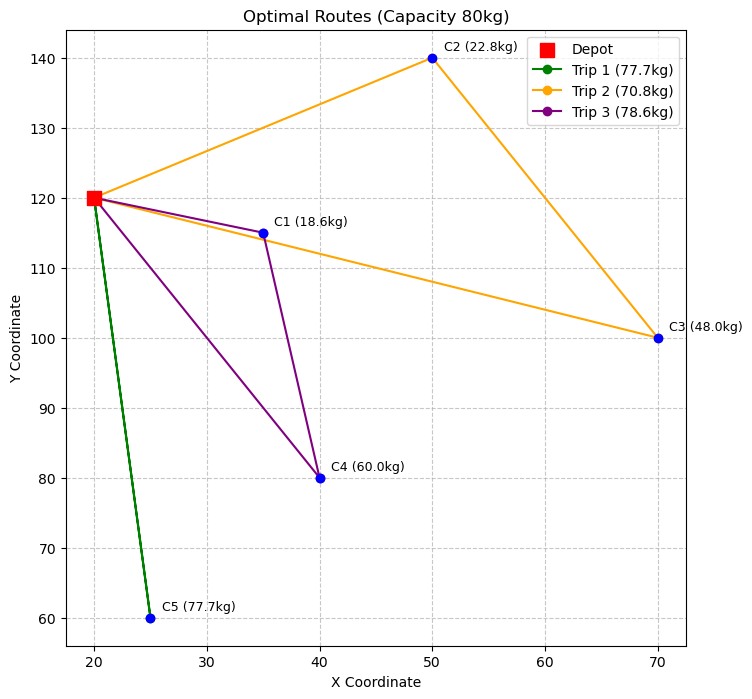

In [6]:
def plot_routes(routes):
    plt.figure(figsize=(8, 8))
    # Draw customers
    for i, (x, y) in enumerate(valid_customers):
        plt.scatter(x, y, c='blue', zorder=5)
        plt.text(x+1, y+1, f'C{i+1} ({round(valid_demands[i], 1)}kg)', fontsize=9)

    # Draw depot
    plt.scatter(depot[0], depot[1], c='red', s=100, marker='s', label='Depot', zorder=5)

    colors = ['green', 'orange', 'purple', 'cyan']
    
    for i, r in enumerate(routes):
        points = [depot] + [valid_customers[c] for c in r] + [depot]
        xs = [p[0] for p in points]
        ys = [p[1] for p in points]
        load = sum(valid_demands[c] for c in r)
        plt.plot(xs, ys, '-o', color=colors[i % len(colors)], label=f'Trip {i+1} ({round(load, 1)}kg)')

    plt.title(f"Optimal Routes (Capacity {capacity}kg)")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

plot_routes(routes)

## 5. Final Experiment Conclusions (Capacity 80 kg)

The increase in vehicle capacity from 60 kg to **80 kg** has radically transformed the logistical solution. The main conclusions are:

1.  **Total Viability (C5 Included):**
    * The most critical factor is the inclusion of **Customer 5** (77.7 kg). By increasing capacity, this customer, which previously represented a lost sale or a logistical exception, now falls within standard operational parameters.
    
2.  **Load Optimization (High Filling Rate):**
    * A much more efficient **fleet saturation** is observed.
    * The combination of **Customer 4** (60 kg) with **Customer 1** (18.6 kg) totals **78.6 kg**. This represents an occupancy of **98.2%**, an ideal scenario in logistics that was mathematically impossible with the 60 kg constraint.
    * Customer 5 occupies **97.1%** of a vehicle on their own, justifying a dedicated trip.

3.  **Route Consolidation:**
    * Unlike the previous scenario where vehicles traveled with partial loads (e.g., 48 kg of 60 = 80%), here more merchandise is moved (all customers) with almost total use of available space on each trip.
    * This demonstrates that a **33% increase in capacity** (from 60 to 80) not only allows serving larger customers but drastically improves the combinatorial efficiency of the rest of the fleet.